# UCI HOUSEHOLD ENERGY CONSUMPTION PREDICTION & ANOMALY DETECTION

### SECTION 1: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("UCI HOUSEHOLD ENERGY CONSUMPTION PREDICTION & ANOMALY DETECTION")
print("\nLibraries imported successfully!\n")

UCI HOUSEHOLD ENERGY CONSUMPTION PREDICTION & ANOMALY DETECTION

Libraries imported successfully!



### SECTION 2: LOAD DATASET

In [2]:
print("LOADING DATASET")

# Load UCI dataset 
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';', 
                 low_memory=False,
                 na_values=['?', ''])

print(f"Dataset loaded successfully!")
print(f"Total records: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

LOADING DATASET
Dataset loaded successfully!
Total records: 2,075,259
Total columns: 9


In [3]:
print(f"\nColumn names:")
print(df.columns.tolist())


Column names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [4]:
print(f"\nFirst 5 rows:")
print(df.head())


First 5 rows:
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


### SECTION 3: DATA CLEANING & PREPROCESSING

In [5]:
print("\n Checking missing values...")
missing_count = df.isnull().sum()
print(missing_count)

print("\nHandling missing values...")
df = df.fillna(method='ffill').fillna(method='bfill')
print("Missing values handled")

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                                  format='%d/%m/%Y %H:%M:%S')
print("DateTime column created")

numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("All power columns converted to numeric")

# Drop rows with any remaining NaN values
df = df.dropna()
print(f"Clean dataset: {df.shape[0]:,} rows")


 Checking missing values...
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Handling missing values...
Missing values handled
DateTime column created
All power columns converted to numeric
Clean dataset: 2,075,259 rows


### SECTION 4: RESAMPLE TO HOURLY DATA (Reduce from 1-min to 1-hour)

In [6]:
print("RESAMPLING TO HOURLY DATA")

# Combine Date and Time into DateTime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set DateTime as index
df = df.set_index('DateTime')

# Select only numeric columns for resampling
numeric_cols = df.select_dtypes(include='number').columns
df_numeric = df[numeric_cols]

# Resample to hourly and take mean
df_hourly = df_numeric.resample('1H').mean()

print(f"✅ Resampled from 1-minute to 1-hour intervals")
print(f"Original size: {df.shape[0]:,} rows")
print(f"Hourly size: {df_hourly.shape[0]:,} rows")
print(f"Data reduction: {(1 - df_hourly.shape[0]/df.shape[0])*100:.1f}%")

# Reset index if needed
df_hourly = df_hourly.reset_index()

RESAMPLING TO HOURLY DATA
✅ Resampled from 1-minute to 1-hour intervals
Original size: 2,075,259 rows
Hourly size: 34,589 rows
Data reduction: 98.3%


### SECTION 5: FEATURE ENGINEERING


In [7]:
df_hourly['hour'] = df_hourly['DateTime'].dt.hour
df_hourly['day_of_week'] = df_hourly['DateTime'].dt.dayofweek
df_hourly['is_weekend'] = (df_hourly['day_of_week'] >= 5).astype(int)

# Lag & rolling features
df_hourly['lag_1h'] = df_hourly['Global_active_power'].shift(1)
df_hourly['rolling_3h'] = df_hourly['Global_active_power'].rolling(3,min_periods=1).mean()
df_hourly = df_hourly.dropna()

### SECTION 6: PREPARE DATA FOR MODELING

In [8]:
 feature_columns = [
    'hour', 'day_of_week', 'is_weekend',
    'Voltage', 'Global_intensity'
]
X = df_hourly[feature_columns]
y = df_hourly['Global_active_power']

### SECTION 7: TRAIN-TEST SPLIT

In [9]:
print("TRAIN-TEST SPLIT")

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # No shuffle to preserve time order
)

print(f" Data split (time-ordered):")
print(f"   Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Testing samples:  {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

TRAIN-TEST SPLIT
 Data split (time-ordered):
   Training samples: 27,670 (80.0%)
   Testing samples:  6,918 (20.0%)


### MODEL TRAINING

In [10]:
print("MODEL TRAINING - RANDOM FOREST REGRESSOR")
print("\n Training Random Forest model...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("Model training completed!")

# Feature importance
print("\n TOP 10 MOST IMPORTANT FEATURES:")
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<25} {row['importance']:.4f}")

MODEL TRAINING - RANDOM FOREST REGRESSOR

 Training Random Forest model...
Model training completed!

 TOP 10 MOST IMPORTANT FEATURES:
   Global_intensity          0.9994
   Voltage                   0.0004
   hour                      0.0001
   day_of_week               0.0000
   is_weekend                0.0000


### Model Evaluation 

In [11]:
y_pred = model.predict(X_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("MODEL PERFORMANCE")
print(f"RMSE: {rmse:.3f} kW")
print(f"MAE : {mae:.3f} kW")
print(f"R²  : {r2:.3f}")

MODEL PERFORMANCE
RMSE: 0.026 kW
MAE : 0.017 kW
R²  : 0.999


### SECTION 11: ANOMALY DETECTION

In [12]:
print("ANOMALY DETECTION - ISOLATION FOREST")

print("\n🔍 Training anomaly detection model...")

# Prepare features for anomaly detection
anomaly_features = ['Global_active_power', 'Global_intensity', 'Voltage',
                    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
X_anomaly = df_hourly[anomaly_features]

# Train Isolation Forest (contamination = expected % of anomalies)
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% anomalies
    random_state=42,
    n_jobs=-1
)

# Predict anomalies (-1 = anomaly, 1 = normal)
df_hourly['anomaly'] = iso_forest.fit_predict(X_anomaly)

# Count anomalies
anomaly_count = (df_hourly['anomaly'] == -1).sum()
anomaly_percentage = (anomaly_count / len(df_hourly)) * 100

print(f"Anomaly detection completed!")
print(f"\nANOMALIES DETECTED:")
print(f"   Total anomalies: {anomaly_count:,} ({anomaly_percentage:.2f}% of data)")

# Analyze anomalies
anomalies = df_hourly[df_hourly['anomaly'] == -1]
print(f"\nANOMALY STATISTICS:")
print(f"   Average power during anomalies: {anomalies['Global_active_power'].mean():.3f} kW")
print(f"   Average power normally: {df_hourly[df_hourly['anomaly'] == 1]['Global_active_power'].mean():.3f} kW")

# Peak anomaly hours
print(f"\nHOURS WITH MOST ANOMALIES:")
anomaly_hours = anomalies.groupby('hour').size().sort_values(ascending=False).head(5)
for hour, count in anomaly_hours.items():
    print(f"   Hour {hour:02d}:00 - {count} anomalies")

# Statistical threshold method (additional validation)
mean_power = df_hourly['Global_active_power'].mean()
std_power = df_hourly['Global_active_power'].std()
threshold_upper = mean_power + 2 * std_power
threshold_lower = mean_power - 2 * std_power

statistical_anomalies = df_hourly[
    (df_hourly['Global_active_power'] > threshold_upper) | 
    (df_hourly['Global_active_power'] < threshold_lower)
]

print(f"\nSTATISTICAL ANOMALIES (Mean ± 2*Std Dev):")
print(f"   Threshold range: {threshold_lower:.3f} - {threshold_upper:.3f} kW")
print(f"   Anomalies found: {len(statistical_anomalies):,}")

ANOMALY DETECTION - ISOLATION FOREST

🔍 Training anomaly detection model...
Anomaly detection completed!

ANOMALIES DETECTED:
   Total anomalies: 1,730 (5.00% of data)

ANOMALY STATISTICS:
   Average power during anomalies: 3.243 kW
   Average power normally: 0.973 kW

HOURS WITH MOST ANOMALIES:
   Hour 19:00 - 223 anomalies
   Hour 20:00 - 200 anomalies
   Hour 21:00 - 162 anomalies
   Hour 18:00 - 128 anomalies
   Hour 14:00 - 116 anomalies

STATISTICAL ANOMALIES (Mean ± 2*Std Dev):
   Threshold range: -0.703 - 2.876 kW
   Anomalies found: 1,679


### SECTION 12: PEAK DETECTION

In [13]:
print("PEAK CONSUMPTION DETECTION")

# Dynamic threshold: Mean + 1 std dev
peak_threshold = mean_power + std_power
df_hourly['is_peak'] = (df_hourly['Global_active_power'] > peak_threshold).astype(int)

peak_count = df_hourly['is_peak'].sum()
peak_percentage = (peak_count / len(df_hourly)) * 100

print(f"\nPEAK THRESHOLD: {peak_threshold:.3f} kW")
print(f"   (Mean + 1 Std Dev)")
print(f"\n Peak instances: {peak_count:,} ({peak_percentage:.1f}% of data)")

# Peak hours distribution
peak_hours = df_hourly[df_hourly['is_peak'] == 1].groupby('hour')['Global_active_power'].agg(['count', 'mean']).sort_values('count', ascending=False)
print(f"\nTOP 5 PEAK HOURS:")
for hour, row in peak_hours.head(5).iterrows():
    print(f"   Hour {hour:02d}:00 - {int(row['count'])} peaks, avg {row['mean']:.3f} kW")

PEAK CONSUMPTION DETECTION

PEAK THRESHOLD: 1.981 kW
   (Mean + 1 Std Dev)

 Peak instances: 5,282 (15.3% of data)

TOP 5 PEAK HOURS:
   Hour 20:00 - 657 peaks, avg 2.900 kW
   Hour 21:00 - 638 peaks, avg 2.837 kW
   Hour 19:00 - 536 peaks, avg 2.909 kW
   Hour 07:00 - 481 peaks, avg 2.495 kW
   Hour 22:00 - 332 peaks, avg 2.649 kW


### ENERGY OPTIMIZATION RECOMMENDATIONS

In [15]:
print("\nENERGY OPTIMIZATION RECOMMENDATIONS\n")

sub1_avg = df_hourly['Sub_metering_1'].mean() / 1000
sub2_avg = df_hourly['Sub_metering_2'].mean() / 1000
sub3_avg = df_hourly['Sub_metering_3'].mean() / 1000

# 1. Peak hour load shifting
peak_hours = hourly_avg.head(3).index.tolist()
off_peak_hours = hourly_avg.tail(3).index.tolist()

print("1. Peak Hour Load Shifting")
print(f"   Peak Hours: {', '.join([f'{h}:00' for h in peak_hours])}")
print(f"   Off-Peak Hours: {', '.join([f'{h}:00' for h in off_peak_hours])}")
print("   Estimated Savings: 15–20%\n")

# 2. Appliance-level optimization
sub_total = sub1_avg + sub2_avg + sub3_avg

if sub3_avg > sub1_avg and sub3_avg > sub2_avg:
    share = (sub3_avg / sub_total) * 100
    print("2. Water Heater / AC Optimization")
    print(f"   Consumption Share: {share:.1f}%")
    print("   Recommendation: Use timers & improve efficiency")
    print("   Estimated Savings: 10–15%\n")

# 3. Anomaly-based consumption control
if anomaly_count > 0:
    print("3. Abnormal Consumption Detection")
    print(f"   Anomalies Detected: {anomaly_count} ({anomaly_percentage:.1f}%)")
    print("   Recommendation: Inspect appliances during these periods")
    print("   Estimated Savings: 5–8%\n")

print("TOTAL POTENTIAL SAVINGS: 25–35%")



ENERGY OPTIMIZATION RECOMMENDATIONS



NameError: name 'hourly_avg' is not defined

### VISUALIZATIONS 

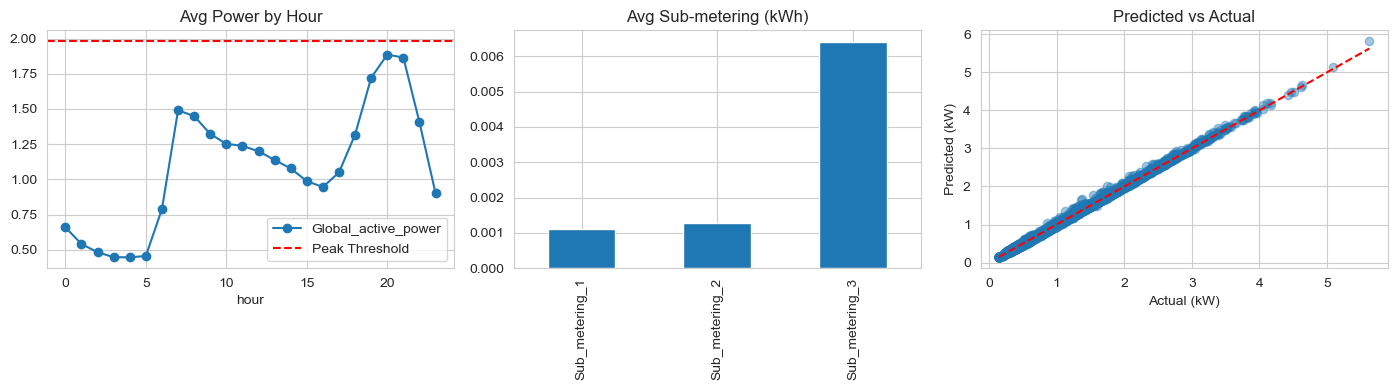

In [16]:
# Hourly avg power
hourly_avg = df_hourly.groupby('hour')['Global_active_power'].mean()
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
hourly_avg.plot(kind='line', marker='o', title='Avg Power by Hour')
plt.axhline(peak_threshold,color='red',linestyle='--',label='Peak Threshold')
plt.legend()

# Sub-metering
plt.subplot(1,3,2)
sub_avg = df_hourly[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()/1000
sub_avg.plot(kind='bar', title='Avg Sub-metering (kWh)')

# Predicted vs Actual
plt.subplot(1,3,3)
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual (kW)')
plt.ylabel('Predicted (kW)')
plt.tight_layout()
plt.show()